In [1]:
import numpy as np
import matplotlib.pyplot as plt

start = 0
end = 10
res = 100
grid = np.linspace(start, end, res)
dx = (end - start) / res

In [2]:
X = 64
dx = 1 / X
domain = np.linspace(0, 1, X)
x, y = np.meshgrid(domain, domain)

# test case with dirichlet BC
p_truth = np.sin(np.pi* x) * np.sin(np.pi * y)
u = -2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)

In [3]:
prt_stp = 10

def plt_diff(solved, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    im1 = ax1.imshow(p_truth)
    im2 = ax2.imshow(solved)
    im3 = ax3.imshow(p_truth - solved)
    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)
    plt.title(title)
    plt.show()

In [4]:
INT = np.s_[1:-1, 1:-1]
XIN = np.s_[2:  , 1:-1]
XMI = np.s_[ :-2, 1:-1]
YIN = np.s_[1:-1, 2:  ]
YMI = np.s_[1:-1,  :-2]


def div(f):
    return (f[XIN][..., 0] - f[XMI][..., 0] + f[YIN][..., 1] - f[YMI][..., 1])


def lap(f, h):
    return (f[XIN] + f[XMI] + f[YIN] + f[YMI] - 4 * f[INT]) * 1/(h*h)


# ∇² phi (r) = rho (r)
def solve_poisson_jacobi(phi, rho, h, iters):
    l1 =  np.zeros((iters))
    # rho_(i,j) * h²
    rhs = rho[INT] * (h*h)
    phi_next = np.zeros_like(phi)
    for i in range(iters):
        phi_next[INT] = 1/4 * (phi[XIN] + phi[XMI] + phi[YIN] + phi[YMI] - rhs)
        phi, phi_next = phi_next, phi
        
        l1[i] = abs(p_solved - phi).sum()
            
    return phi, l1
        

NameError: name 'p_solved' is not defined

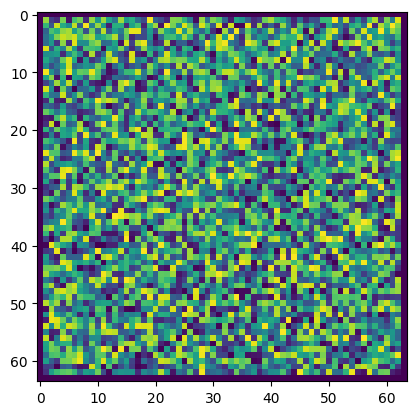

In [5]:
p = np.random.rand(X, X)
p[0, :] = 0
p[-1, :] = 0
p[1:-1, 0] = 0
p[1:-1, -1] = 0
plt.imshow(p)
# cfd: p = ∇⋅u
p_solved, l1 = solve_poisson_jacobi(p.copy(), u, dx, X * X)

plt_diff(p_solved, 'final step')



In [ ]:
plt.plot(l1)


## Lets check Jacobi stability

When running simulations, we update pressure each frame by a given amount of iteration.
To fully solve pressure, we should run X² iteration, with X being the grid resolution (square grid).
but instead, we run n iter, n < X² (50 to 200 in our case) which should be far to low to obtain a correct pressure but surprisingly, our simulations results are not that far from other papers.
Since jacobi is convergent, a solution is reached faster when provided an initial good guess. According to that, our explanation lies in the fact the n iterations provides more convergence from p to p+1 (pressure at next step) than diffusion and convergence provide divergence.

To verify this hypothesis, we require the following constraints:
- Jacobi convergence should be scaling linearly, as in the scale of values used do not matter
- Jacobi should handle the local divergence rate induced from convergence and diffusion even if they spike at certain locations.

In [ ]:
# First test: p is solved for n then modified by noise of factor a
%matplotlib inline
# u = lap(p)

def run_exp(a, n, factor=1):
    p_truth = np.sin(np.pi* x * factor) * np.sin(np.pi * y * factor) 
    u = -2 * np.pi**2 * factor * factor * np.sin(np.pi * x * factor) * np.sin(np.pi * y * factor) 
    
    p = np.random.rand(X, X) * factor
    p[0, :] = 0
    p[-1, :] = 0
    p[1:-1, 0] = 0
    p[1:-1, -1] = 0
    
    
    steps = 100
    cum_l1 = []
    p_advanced = p
    for step in range(steps):
        p_advanced, l1 = solve_poisson_jacobi(p_advanced.copy(), u, dx, n)
        p_advanced += np.linalg.norm(p_advanced) * np.random.rand(X, X) * a
        cum_l1.append(l1)
    
    cum_l1 = np.concatenate(cum_l1)
    plt.plot(cum_l1, label=f'a:{a}{f", scale:{factor}" if factor != 1 else ""}')

interval = 50
run_exp(0.0, interval)
run_exp(0.0001, interval)
#run_exp(0.001, interval)
#run_exp(0.01, interval)
plt.legend()
plt.ylabel('l1 loss')
plt.xlabel('iteration')
plt.title(f'Comparaison of different divergence a applied every {interval} steps')
plt.show()

In [ ]:
interval = 50
factor = 10
run_exp(0.0, interval, factor = factor)
run_exp(0.0001, interval, factor = factor)
#run_exp(0.001, interval, factor = factor)
#run_exp(0.01, interval, factor = factor)
#run_exp(0.1, interval, factor = factor)
plt.legend()
plt.ylabel('l1 loss')
plt.xlabel('iteration')
plt.title(f'Comparaison of different divergence a applied every {interval} steps')
plt.show()

In [ ]:


interval = 200
run_exp(0.0, interval)
run_exp(0.0001, interval)
run_exp(0.001, interval)
#run_exp(0.01, interval)
plt.legend()
plt.ylabel('l1 loss')
plt.xlabel('iteration')
plt.title(f'Comparaison of different divergence a applied every {interval} steps')
plt.show()

In my current solver, diff of U in % from one iter to another (a) is of scale 1e-7 at dt 1e-4 RE5000 X=257, n = 200

In [ ]:
X = 257
dx = 1 / X
domain = np.linspace(0, 1, X)
x, y = np.meshgrid(domain, domain)

    
def run_exp(a, n, factor=1):
    p_solved = np.sin(np.pi* x * factor) * np.sin(np.pi * y * factor) 
    u = -2 * np.pi**2 * factor * factor * np.sin(np.pi * x * factor) * np.sin(np.pi * y * factor)

        # ∇² phi (r) = rho (r)
    def solve_poisson_jacobi(phi, rho, h, iters):
        l1 =  np.zeros((iters))
        # rho_(i,j) * h²
        rhs = rho[INT] * (h*h)
        phi_next = np.zeros_like(phi)
        for i in range(iters):
            phi_next[INT] = 1/4 * (phi[XIN] + phi[XMI] + phi[YIN] + phi[YMI] - rhs)
            phi, phi_next = phi_next, phi
            
            l1[i] = abs(p_solved - phi).sum()
                
        return phi, l1

    p = np.random.rand(X, X) * factor
    p[0, :] = 0
    p[-1, :] = 0
    p[1:-1, 0] = 0
    p[1:-1, -1] = 0
    
    
    steps = 100
    cum_l1 = []
    p_advanced = p
    for step in range(steps):
        p_advanced, l1 = solve_poisson_jacobi(p_advanced.copy(), u, dx, n)
        p_advanced += np.linalg.norm(p_advanced) * np.random.rand(X, X) * a
        cum_l1.append(l1)
    
    cum_l1 = np.concatenate(cum_l1)
    plt.plot(cum_l1, label=f'a:{a}{f", scale:{factor}" if factor != 1 else ""}')

    
interval = 20
run_exp(0.0, interval)
run_exp(1e-6, interval)
#run_exp(0.01, interval)
plt.legend()
plt.ylabel('l1 loss')
plt.xlabel('iteration')
plt.title(f'Comparaison of different divergence a applied every {interval} steps')
plt.show()

When using n = 20; we still converge with a of scale 1e-7 so pressure iteration can be reduced in my solver!